In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import numpy as np
from pathlib import Path
from dewan_calcium.helpers import DewanCombineData

In [24]:
# VGAT 4 Odor Data is in a strange order, for now, we're going to ignore it since 5 and 12 line up perfectly

root_path = Path('Z:/2_Inscopix/1_DTT/1_OdorAnalysis/') # Root Data Path
preprocess_paths, auroc_data_paths, odor_data_paths, experiment_folders = DewanCombineData.load_paths(root_path)
experiment_names = [folder.name for folder in experiment_folders]
ontime_auroc_paths, latent_auroc_paths = DewanCombineData.get_data_file_paths(auroc_data_paths)
on_time_data, latent_data, odor_data = DewanCombineData.load_raw_data(ontime_auroc_paths, latent_auroc_paths, odor_data_paths)

In [25]:
# This is a fix for the ID data in index 1 of Odor Data
new_odors = []

for odor in odor_data[1]:
    if odor == 'Buzzer' or odor == 'MO':
        new_odors.append(odor)
        continue
    
    for index, char in enumerate(odor):
        if char.isdigit():
            first_split = odor[:index+1]
            second_split = odor[index+1:]
            new_odor = f'{first_split}-{second_split}'
            new_odors.append(new_odor)  
            
odor_data[1] = new_odors

In [26]:
new_odor_indexes, unique_odors = DewanCombineData.get_new_odor_indexes(odor_data)

In [27]:
# For each experiment, we collect all cells into one array per experiment
stacked_on_time_data = DewanCombineData.coalesce_cells(on_time_data)
stacked_latent_data = DewanCombineData.coalesce_cells(latent_data)

In [28]:
# Remove Nonzero Cells
filtered_on_time_data = DewanCombineData.remove_nonzero_cells(stacked_on_time_data)
filtered_latent_data = DewanCombineData.remove_nonzero_cells(stacked_latent_data)

In [29]:
# Reorder data by new odor indexes 
odor_sorted_on_time_data = DewanCombineData.sort_data_by_odor_indexes(filtered_on_time_data, new_odor_indexes)
odor_sorted_latent_data = DewanCombineData.sort_data_by_odor_indexes(filtered_latent_data, new_odor_indexes)

In [30]:
# Sort into 3 groups, excititory, both, inhibitory
sorted_on_time_data = DewanCombineData.sort_by_responses(filtered_on_time_data)
sorted_latent_data = DewanCombineData.sort_by_responses(filtered_latent_data)

In [35]:
# Relabel latent data and combine it with the ontime data
relabeled_latent_data = DewanCombineData.relabel_latent_data(sorted_latent_data)
combined_data = DewanCombineData.combine_data(sorted_on_time_data, relabeled_latent_data)

In [37]:
# Sort the data by the sum of its rows
sum_sorted_on_time_data = DewanCombineData.sort_by_sum(sorted_on_time_data)
sum_sorted_latent_data = DewanCombineData.sort_by_sum(sorted_latent_data)
sum_sorted_combined_data = DewanCombineData.sort_by_sum(combined_data)

In [74]:
# Calculate Cell Totals
total_on_time_conc_cells, total_on_time_num_ID_cells = [len(experiment) for experiment in stacked_on_time_data]
total_latent_conc_cells, total_latent_ID_cells = [len(experiment) for experiment in stacked_latent_data]
significant_on_time_conc_cells, significant_on_time_num_ID_cells = [len(experiment) for experiment in filtered_on_time_data]
significant_latent_conc_cells, significant_latent_ID_cells = [len(experiment) for experiment in filtered_latent_data]
num_conc_cells, num_ID_cells = [np.sum([len(row) for row in experiment]) for experiment in combined_data]

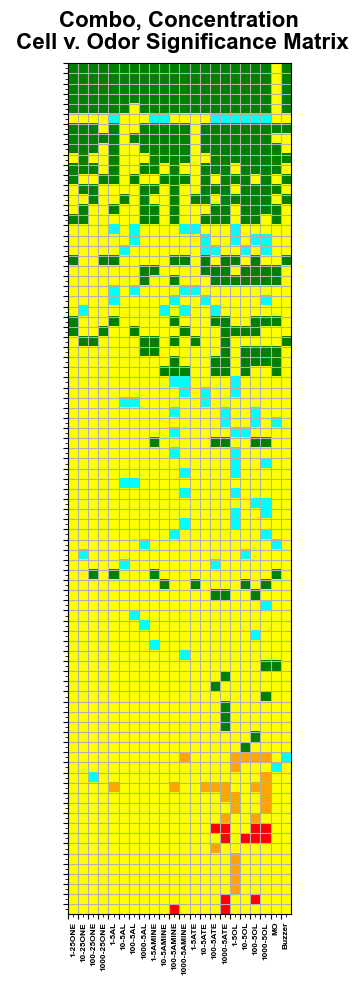

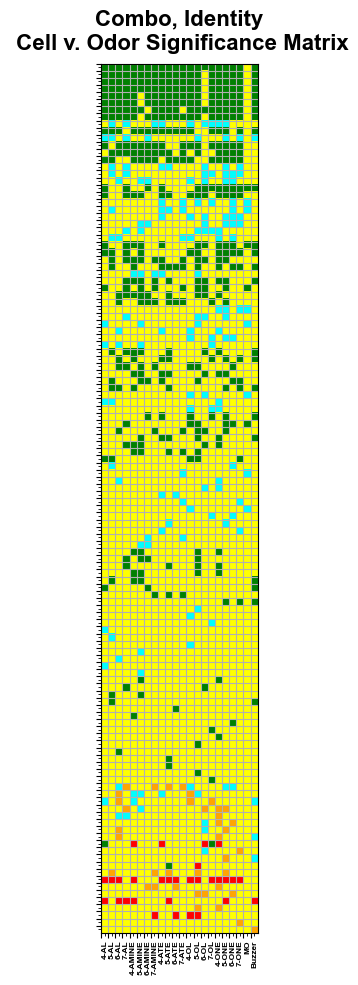

In [38]:
DewanCombineData.plot_matrix(sum_sorted_on_time_data, unique_odors, experiment_names, 'On-Time') # On-Time Plots
DewanCombineData.plot_matrix(sum_sorted_latent_data, unique_odors, experiment_names, 'Latent') # Latent Plots
DewanCombineData.plot_matrix(sum_sorted_combined_data, unique_odors, experiment_names, 'Combo') # Combined Plots

In [ ]:
# # Sort and compile data for plotting
# 
# data = cell_data_by_cluster
# plot_names = [[f'Cluster{i}'] for i in range(len(data))]
# unique_odors = np.unique(odor_data)
# num_unique_odors = len(unique_odors)
# ratios = tuple([len(cell)/len(data[0]) for cell in data])
# 
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# 
# mpl.rcParams['font.family'] = 'Arial'
# colormap = ListedColormap(['yellow', 'red', 'green'])
# 
# fig, ax = plt.subplot_mosaic(plot_names, gridspec_kw={'height_ratios': ratios, 'hspace': 0}, sharex=True, figsize=(5, 8))
# # This took HOURS. We calculate radios based off the number of cells so everything is scaled to the first set of data
# # One, common x axis and no space between subplots
# 
# for i, label in enumerate(ax): # Loop through each axis (experiment-animal pairing)
#     each = ax[label]
#     num_cells = len(data[i])
# 
#     each.imshow(data[i], cmap=colormap, extent=(0, num_unique_odors, num_cells, 0))
# 
#     each.set_yticks(np.arange(num_cells), labels=[]) # Set major ticks but leave them unlabeled
#     each.set_xticks(np.arange(num_unique_odors), labels=[])
#     each.set_yticks(np.arange(0.5, num_cells + 0.5, 1), labels=[], minor=True, fontsize=6) # Set minor ticks (offset by 0.5) and label them
# 
#     each.set_ylabel(plot_names[i][0], fontsize=7, fontweight='bold') # Set y-axis label to animal-experiment pairing
# 
#     each.grid(which='major') # Show the major grid to make nice little squares
# 
# bottom_ax = ax[plot_names[-1][0]] # Grab the last axis (we will label the x-axis on this one)
# bottom_ax.set_xticks(np.arange(0.5, num_unique_odors + 0.5, 1), rotation=90, ha='center', labels=unique_odors, minor=True, fontsize=6, fontweight='bold') # Label the bottommost x-axis with the odors
# bottom_ax.set_xlabel('Odors', fontweight = 'bold', fontsize=10)
# 
# 
# #plt.suptitle('Latent \n Cell v. Odor Significance Matrix', fontsize=16, fontweight='bold') # Set the main title
# plt.tight_layout(rect=(0, 0, 1, 0.98)) # Squish the graphs into a box just 'slightly' smaller than max, so theres room for the title
# #plt.show()
# plt.savefig('Clusters.pdf', dpi=900) # Save in *Sportscaster Voice* HIGH DEFINITION